---
## Step one: load the required libraries

In [1]:
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F
from pyspark.sql.functions import when, col
from pyspark.ml.feature import (
    Bucketizer,
    OneHotEncoder,
    StringIndexer, 
)
from pyspark.ml import Pipeline
from pyspark.ml.classification import (
    LogisticRegression,
    RandomForestClassifier,
)
from pyspark.ml.evaluation import (
    BinaryClassificationEvaluator,
    MulticlassClassificationEvaluator,
    RegressionEvaluator,
)
from pyspark.ml.feature import SQLTransformer
from pyspark.ml.feature import (
    StringIndexer,
    VectorAssembler,
    StandardScaler
)
from pyspark.ml.regression import RandomForestRegressor
from pyspark.mllib.evaluation import (
    BinaryClassificationMetrics,
    MulticlassMetrics, 
)
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.mllib.linalg import DenseMatrix
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Create Spark session
spark = SparkSession.builder\
    .appName("census_data") \
    .getOrCreate()
# Set the logging level to ERROR
spark.sparkContext.setLogLevel("ERROR")
nltk.download('wordnet', quiet=True)

your 131072x1 screen size is bogus. expect trouble
23/08/06 16:00:04 WARN Utils: Your hostname, LAPTOP resolves to a loopback address: 127.0.1.1; using 172.28.76.17 instead (on interface eth0)
23/08/06 16:00:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/06 16:00:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


True

## Step Two: load the data

In [2]:
data = spark.read.csv(
    "adult.csv", 
    escape='"',
    header=True, 
    inferSchema=True,
)


In [3]:
data.show()

+---+----------------+------+------------+---------------+------------------+-----------------+-------------+------------------+------+------------+------------+--------------+--------------+------+
|age|       workclass|fnlwgt|   education|educational-num|    marital-status|       occupation| relationship|              race|gender|capital-gain|capital-loss|hours-per-week|native-country|income|
+---+----------------+------+------------+---------------+------------------+-----------------+-------------+------------------+------+------------+------------+--------------+--------------+------+
| 25|         Private|226802|        11th|              7|     Never-married|Machine-op-inspct|    Own-child|             Black|  Male|           0|           0|            40| United-States| <=50K|
| 38|         Private| 89814|     HS-grad|              9|Married-civ-spouse|  Farming-fishing|      Husband|             White|  Male|           0|           0|            50| United-States| <=50K|
| 28|

## Step Three + Four: Explore the data + Clean the data

Doing some basic exploration of the data to start understanding the data and what it looks like.

In [4]:
data = data.drop("fnlwgt")

In [5]:
for col, dtype in data.dtypes:
    data = data.withColumnRenamed(col, col.replace("-", "_"))

In [6]:
numerical = []
strings = []
for col, dtype in data.dtypes:
    if col == "age":
        print(dtype)
    if dtype in ["string"]:
        strings.append(col)
    else:
        numerical.append(col)

int


In [7]:
numerical

['age', 'educational_num', 'capital_gain', 'capital_loss', 'hours_per_week']

In [8]:
strings

['workclass',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'gender',
 'native_country',
 'income']

In [9]:
data.show()

+---+----------------+------------+---------------+------------------+-----------------+-------------+------------------+------+------------+------------+--------------+--------------+------+
|age|       workclass|   education|educational_num|    marital_status|       occupation| relationship|              race|gender|capital_gain|capital_loss|hours_per_week|native_country|income|
+---+----------------+------------+---------------+------------------+-----------------+-------------+------------------+------+------------+------------+--------------+--------------+------+
| 25|         Private|        11th|              7|     Never-married|Machine-op-inspct|    Own-child|             Black|  Male|           0|           0|            40| United-States| <=50K|
| 38|         Private|     HS-grad|              9|Married-civ-spouse|  Farming-fishing|      Husband|             White|  Male|           0|           0|            50| United-States| <=50K|
| 28|       Local-gov|  Assoc-acdm|     

## Step Five: Feature Engineering

Turn categorical variables into vectorized representations to be used for training.

In [10]:
# Martial Status
binary = False
target = "marital_status"

# # Gender Classification
# binary = True
# target = "gender"


target_index = f"{target}_index"

In [11]:
imputed_stages = []

for col in strings:
    min = data.filter(data[col] != '?').groupBy(col).count().orderBy('count', ascending=True).first()[0]

    sqlTrans = SQLTransformer(
        statement=f"""
        SELECT *, 
        CASE WHEN {col} = '?' THEN True ELSE False END as {col}_is_missing,
        CASE WHEN {col} = '?' THEN '{min}' ELSE {col} END as {col}_imputed
        FROM __THIS__
        """)
    
    imputed_stages.append(sqlTrans)

In [12]:
string_indexers = [StringIndexer(inputCol=f"{col}_imputed", outputCol=f"{col}_index") for col in strings]

In [13]:
one_hot_encoders = [OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_vec") for col in strings]

In [14]:
# Not including the binary indicator that the column was filled
# features = [f"{col}_vec" for col in strings if col != target] + [x for x in numerical if x != "educational_num"]

features = [f"{col}_vec" for col in strings if col != target] + [f"{col}_is_missing" for col in strings if col != target] + [x for x in numerical if x != "educational_num"]


In [15]:
features

['workclass_vec',
 'education_vec',
 'occupation_vec',
 'relationship_vec',
 'race_vec',
 'gender_vec',
 'native_country_vec',
 'income_vec',
 'workclass_is_missing',
 'education_is_missing',
 'occupation_is_missing',
 'relationship_is_missing',
 'race_is_missing',
 'gender_is_missing',
 'native_country_is_missing',
 'income_is_missing',
 'age',
 'capital_gain',
 'capital_loss',
 'hours_per_week']

In [16]:
assembler = VectorAssembler(inputCols=features, outputCol="feature_vector")

In [17]:
scaler = StandardScaler(inputCol="feature_vector", outputCol="scaled_features",
                        withStd=True, withMean=True)


In [18]:
pipeline = Pipeline(stages=imputed_stages + string_indexers + one_hot_encoders + [assembler, scaler])

In [19]:
data = pipeline.fit(data).transform(data)

In [20]:
data.show()

+---+----------------+------------+---------------+------------------+-----------------+-------------+------------------+------+------------+------------+--------------+--------------+------+--------------------+-----------------+--------------------+-----------------+-------------------------+----------------------+---------------------+------------------+-----------------------+--------------------+---------------+------------------+-----------------+--------------+-------------------------+----------------------+-----------------+--------------+---------------+---------------+--------------------+----------------+------------------+----------+------------+--------------------+------------+-------------+---------------+------------------+---------------+----------------+-------------+-------------+------------------+-------------+--------------------+--------------------+
|age|       workclass|   education|educational_num|    marital_status|       occupation| relationship|           

In [21]:
fractions = data.select(target_index).distinct().withColumn("fraction", F.lit(0.8)).rdd.collectAsMap()
train_df = data.stat.sampleBy(target_index, fractions, seed=42)
test_df = data.subtract(train_df)


In [22]:
train_df.show()

+---+----------------+------------+---------------+------------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+--------------------+-----------------+--------------------+-----------------+-------------------------+----------------------+---------------------+------------------+-----------------------+--------------------+---------------+------------+-----------------+--------------+-------------------------+----------------------+-----------------+--------------+---------------+---------------+--------------------+----------------+------------------+----------+------------+--------------------+------------+-------------+--------------+------------------+---------------+----------------+-------------+-------------+------------------+-------------+--------------------+--------------------+
|age|       workclass|   education|educational_num|    marital_status|       occupation| relationship| race|gender|capital_gain|capit

## Step Six: Train and Explore ML algorithms models

In [23]:
if binary:
    trainer = GBTClassifier(labelCol=target_index, featuresCol="scaled_features", maxIter=10)
else:
    trainer = RandomForestClassifier(labelCol=target_index, featuresCol="scaled_features")

In [24]:
model = trainer.fit(train_df)
predictions = model.transform(test_df)

In [25]:
predictions.show()

+---+------------+------------+---------------+------------------+---------------+--------------+-----+------+------------+------------+--------------+--------------+------+--------------------+-----------------+--------------------+-----------------+-------------------------+----------------------+---------------------+------------------+-----------------------+--------------------+---------------+------------+-----------------+--------------+-------------------------+----------------------+-----------------+--------------+---------------+---------------+--------------------+----------------+------------------+----------+------------+--------------------+------------+-------------+---------------+------------------+---------------+----------------+-------------+-------------+------------------+-------------+--------------------+--------------------+--------------------+--------------------+----------+
|age|   workclass|   education|educational_num|    marital_status|     occupation|  

In [26]:
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol=target_index, predictionCol="prediction", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol=target_index, predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol=target_index, predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol=target_index, predictionCol="prediction", metricName="f1")

In [27]:
accuracy = accuracy_evaluator.evaluate(predictions)
precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)
f1_score = f1_evaluator.evaluate(predictions)

# Print metrics
print("Accuracy: ", accuracy)
print("Weighted Precision: ", precision)
print("Weighted Recall: ", recall)
print("F1 Score: ", f1_score)


Accuracy:  0.7607174659712505
Weighted Precision:  0.7100132393713059
Weighted Recall:  0.7607174659712505
F1 Score:  0.7010962244786074


## Step Seven: Visualize the results

/home/main/.local/share/virtualenvs/cosc526_final-hdqxpDEz/lib/python3.10/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


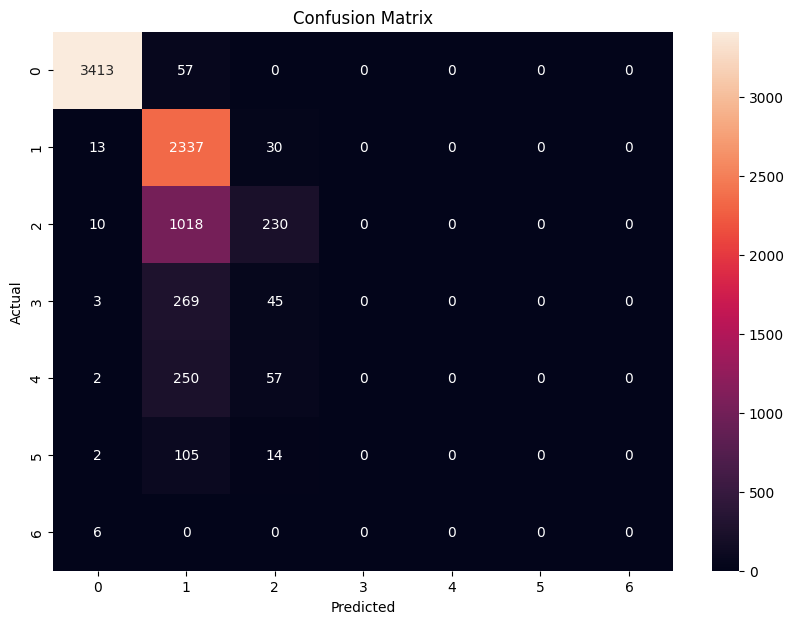

In [28]:
metrics = MulticlassMetrics(predictions.select('prediction', target_index).rdd)
confusion_matrix = metrics.confusionMatrix().toArray()

plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")
plt.show()